# Imports and utility

In [1]:
#d8f53b61969adf7ee621c216f680b707
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras_hub
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet152, EfficientNetB0, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import optimizers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # 0 = todo, 1 = INFO, 2 = WARNING, 3 = ERROR
tf.get_logger().setLevel('ERROR')

train_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
val_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'
test_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
auto_test = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test'
cat_dir = '/kaggle/input/cat-knee/clean'

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SEED = 66


In [2]:
import pandas as pd
import os

def create_dataframe_from_directory(base_dir, regression=False):
    data = []
    for label_str in sorted(os.listdir(base_dir)):
        label_path = os.path.join(base_dir, label_str)
        if not os.path.isdir(label_path):
            continue
        label = float(label_str) if regression else label_str
        for fname in os.listdir(label_path):
            data.append({
                'filename': os.path.join(label_str, fname),  # ruta relativa
                'label': label  # KL debe ser numérico para regresión
            })
    return pd.DataFrame(data)

In [3]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
import tensorflow as tf

class CatValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, cat_generator, regresion=False, filepath='best_model_cat.keras'):
        super().__init__()
        self.cat_generator = cat_generator
        self.epoch_metrics = []
        self.regresion = regresion
        self.filepath = filepath
        # Inicializamos best_score y best_loss
        if regresion:
            self.best_score = 0.0    # queremos maximizar accuracy
            self.best_loss  = np.inf # y minimizar MAE
        else:
            self.best_score = 0.0    # queremos maximizar accuracy
            self.best_loss  = np.inf # y minimizar categorical loss

    def on_epoch_end(self, epoch, logs=None):
        # Predicciones
        preds = self.model.predict(self.cat_generator, verbose=0)

        if self.regresion:
            # Regresión: calculamos MAE + accuracy sobre clases redondeadas
            y_pred = preds.flatten()
            y_true = self.cat_generator.labels
            loss = mean_absolute_error(y_true, y_pred)
            y_pred_class = np.clip(np.round(y_pred), 0, 4).astype(int)
            y_true_class = np.clip(np.round(y_true), 0, 4).astype(int)
            acc = accuracy_score(y_true_class, y_pred_class)
            score = acc
        else:
            # Clasificación: evalúa el loss y la accuracy
            loss, acc = self.model.evaluate(self.cat_generator, verbose=0)
            preds_class = np.argmax(preds, axis=1)
            y_true = self.cat_generator.classes
            # para consistency, recalculamos acc con sklearn
            acc = accuracy_score(y_true, preds_class)
            score = acc

        # Guardar métricas
        self.epoch_metrics.append({
            'epoch': epoch + 1,
            'val_cat_loss': loss,
            'val_cat_accuracy': acc
        })

        # Mostrar por consola
        tag = "MAE" if self.regresion else "Loss"
        print(f"🐾 [Cat Val] {tag}: {loss:.4f} | Accuracy: {acc:.4f}")

        # Comprobamos mejora: primero por score, si empate por loss
        improved = False
        if score > self.best_score:
            improved = True
        elif score == self.best_score and loss < self.best_loss:
            improved = True

        # Si mejoró, guardamos modelo y actualizamos referencias
        if improved:
            self.best_score = score
            self.best_loss  = loss
            self.model.save(self.filepath)
            print(f"📦 Modelo mejorado guardado en {self.filepath}")


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

def get_callbacks(regression=False, cat_gen=None):
  cat_val_cb = CatValidationCallback(cat_gen, regresion=regression)
  

  checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',         # nombre de la métrica a monitorizar
    mode='max',                     # porque buscamos la mayor precisión
    save_best_only=True,
    save_weights_only=False,
    verbose=1
  )
  checkpoint_cb_reg = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
  )
  if regression:
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
        cat_val_cb,
        checkpoint_cb_reg
    ]
  else:
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
        cat_val_cb,
        checkpoint_cb
    ]
  return callbacks


In [5]:
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def _get_label_map(y_true, y_pred, generator=None, default_prefix="KL"):
    """
    Genera un mapa de etiquetas automáticamente:
    - Si el generador tiene `class_indices`, lo usa.
    - Si no, extrae las clases únicas de `y_true` y `y_pred`.
    - Si todo falla, crea etiquetas "KL 0", "KL 1", ..., según el número de clases.
    """
    # Caso Keras ImageDataGenerator con class_indices
    if generator is not None and hasattr(generator, 'class_indices'):
        sorted_items = sorted(generator.class_indices.items(), key=lambda x: x[1])
        return [name for name, _ in sorted_items]

    # Extraer clases únicas
    classes = np.unique(np.concatenate((y_true, y_pred)))

    # Si son enteros consecutivos desde 0 a n-1
    if np.array_equal(classes, np.arange(len(classes))):
        return [f"{default_prefix} {i}" for i in classes]

    # En otro caso, convertir cada clase a string
    return [str(c) for c in classes]


def evaluate_classification(y_true, y_pred, label_map=None, digits=4, title_suffix=""):
    """
    Imprime el reporte de clasificación y muestra la matriz de confusión.
    """
    if label_map is None:
        label_map = _get_label_map(y_true, y_pred)

    # Reporte de métricas
    print(classification_report(
        y_true,
        y_pred,
        target_names=label_map,
        digits=digits
    ))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_map,
        yticklabels=label_map
    )
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta verdadera')

    if title_suffix:
        plt.title(title_suffix)

    plt.show()


def evaluate_model(model, regression, generator, label_map=None, digits=4):
    """
    Evalúa un modelo de Keras:
    - Si `regression=True`, calcula MAE y scatter plot, luego convierte a clases para el reporte.
    - Si `regression=False`, calcula reporte y matriz de confusión directamente.

    Parámetros:
    - model: modelo Keras ya entrenado.
    - regression: bool, True para regresión.
    - generator: generador Keras (ImageDataGenerator).
    - label_map: lista opcional de nombres de clases.
    - digits: número de dígitos en el reporte.
    """
    # Predicciones
    preds = model.predict(generator)

    if regression:
        # Valores continuos
        if hasattr(generator, 'labels'):
            y_true_cont = np.array(generator.labels).flatten()
        else:
            y_true_cont = np.array(generator.classes).flatten()
        y_pred_cont = preds.flatten()

        # MAE y scatter
        mae = mean_absolute_error(y_true_cont, y_pred_cont)
        print(f"Mean Absolute Error (MAE): {mae:.{digits}f}\n")

        plt.figure(figsize=(6, 6))
        plt.scatter(y_pred_cont, y_true_cont, alpha=0.5)
        mn, mx = min(y_true_cont.min(), y_pred_cont.min()), max(y_true_cont.max(), y_pred_cont.max())
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        plt.xlabel("Predicción (decimal)")
        plt.ylabel("Valor verdadero")
        plt.title("Scatter: Predicción vs Valor verdadero")
        plt.grid(True)
        plt.show()

        # Convertir a clases enteras
        y_true_cls = np.clip(np.round(y_true_cont).astype(int), 0, None)
        y_pred_cls = np.clip(np.round(y_pred_cont).astype(int), 0, None)

        if label_map is None:
            max_lbl = max(y_true_cls.max(), y_pred_cls.max())
            label_map = [f"KL {i}" for i in range(max_lbl + 1)]

        evaluate_classification(y_true_cls, y_pred_cls, label_map, digits)

    else:
        # Clasificación multiclase
        y_pred = np.argmax(preds, axis=1)
        y_true = generator.classes

        if label_map is None:
            label_map = _get_label_map(y_true, y_pred, generator)

        evaluate_classification(y_true, y_pred, label_map, digits)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def get_datagen(
    tarea: int,
    path: str,
    regression: bool = False,
    IMG_SIZE: tuple = (224, 224),
    BATCH_SIZE: int = 32,
    SEED: int = 42,
    augment: bool = False
):
    """
    Generador de imágenes para clasificación y regresión con distintos esquemas de tarea.

    Parámetros:
        tarea       – entero 0–5 que define esquema de etiquetas.
        path        – ruta al directorio de imágenes (train/val/test u otro).
        regression  – True para regresión (class_mode='raw'), False para clasificación.
        IMG_SIZE    – tupla (alto, ancho).
        BATCH_SIZE  – tamaño de lote.
        SEED        – semilla aleatoria.
        augment     – True para data augmentation (solo en entrenamiento).
    """
    # Configurar DataGenerator
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
        shuffle = True
    else:
        datagen = ImageDataGenerator(rescale=1./255)
        shuffle = False

    # Cargar dataframe con tu función; label como float si regresión, str si clasificación
    df = create_dataframe_from_directory(path, regression=regression)
    # Clasificación: convertir labels a ints para procesar tareas
    df_proc = df.copy()
    df_proc['label'] = df_proc['label'].astype(int)

    if tarea == 0:
        # Multiclase original 0–4: no cambio
        pass
    elif tarea == 1:
        df_proc['label'] = df_proc['label'].apply(
            lambda x: 0 if x in [0,1,2] else 1 if x == 3 else 2 if x == 4 else x
        )
    elif tarea in [2,3,4,5]:
        target = tarea - 1  # tarea=2->1, etc.
        df_proc = df_proc[df_proc['label'].isin([0, target])]
        df_proc['label'] = df_proc['label'].apply(lambda x: 1 if x == target else 0)
    elif tarea == 6:
        print("Detección binaria de artrosis")
        df_proc['label'] = df_proc['label'].apply(
            lambda x: 0 if x in [0] else 1
        )
    else:
        raise ValueError("tarea debe ser un entero entre 0 y 5.")

    if regression:
        # Asegurar float
        df_proc['label'] = df_proc['label'].astype(float)
        return datagen.flow_from_dataframe(
            dataframe=df_proc,
            directory=path,
            x_col='filename',
            y_col='label',
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='raw',
            shuffle=shuffle,
            seed=SEED
        )
    # Convertir a string para class_mode='categorical'
    df_proc['label'] = df_proc['label'].astype(str)
    
    # Generador de clasificación
    return datagen.flow_from_dataframe(
        dataframe=df_proc,
        directory=path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle,
        seed=SEED
    )


## Experimentos a realizar

Normal 
012-3-4
0-1
0-2
0-3
0-4

In [7]:
def cnn_pequeno(num_classes = 5, regression=False):
    activation = 'linear' if regression else 'softmax'
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu',
                      input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(num_classes, activation=activation)
    ])
    return model

In [8]:
def cnn_mediana(num_classes, regression=False):
    activation = 'linear' if regression else 'softmax'
    model = models.Sequential([
        # Primera capa convolucional
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPooling2D((2, 2)),
        # Segunda capa convolucional
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Aplanamiento y capas densas
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation=activation)
    ])
    return model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D, Dropout,
    Flatten, Dense
)

def cnn_grande(num_classes, regression = False):
    activation = 'linear' if regression else 'softmax'
    model = Sequential(name="CNN_Profunda")

    # Bloque 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Bloque 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Bloque 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.40))

    # Clasificación final
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))

    return model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, BatchNormalization,
    Dropout, Dense
)
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7

def efficientnetB0_model(num_classes, regression=False, frozen=False):
    """
    Modelo basado en EfficientNetB0 con cabeza personalizada.
    - Input: 224×224×3
    - Preentrenado en ImageNet
    - Arquitectura secuencial
    """
    activation = 'linear' if regression else 'softmax'
    # Cargamos la base EfficientNetB0 sin la capa superior
    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    if frozen:
        base.trainable = False
    model = Sequential(name="EfficientNetB0_Custom")
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))
    return model

def efficientnetB7_model(num_classes, regression=False):
    """
    Modelo basado en EfficientNetB7 con cabeza personalizada.
    - Preentrenado en ImageNet
    - Arquitectura secuencial
    """
    activation = 'linear' if regression else 'softmax'
    base = EfficientNetB7(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    model = Sequential(name="EfficientNetB7_Custom")
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))
    return model


In [11]:
def simple_transformer(num_classes=5, regression=False):
    activation = 'linear' if regression else 'softmax'

    inputs = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.Reshape((-1, 32))(x)
    x = layers.MultiHeadAttention(num_heads=1, key_dim=4)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation=activation)(x)

    model = models.Model(inputs, outputs)
    return model

Detección binaria de artrosis
Found 5778 validated image filenames belonging to 2 classes.
Detección binaria de artrosis
Found 826 validated image filenames belonging to 2 classes.
Detección binaria de artrosis
Found 83 validated image filenames belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5775 - loss: 1.0736🐾 [Cat Val] Loss: 0.5922 | Accuracy: 0.7349
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_accuracy improved from -inf to 0.60291, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 218s 812ms/step - accuracy: 0.5776 - loss: 1.0726 - val_accuracy: 0.6029 - val_loss: 0.6748 - learning_rate: 0.0010
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6948 - loss: 0.6201🐾 [Cat Val] Loss: 0.6703 | Accuracy: 0.6265

Epoch 2: val_accuracy did not improve from 0.60291
181/181 ━━━━━━━━━━━━━━━━━━━━ 67s 357ms/step - accuracy: 0.6949 - loss: 0.6199 - val_accuracy: 0.3959 - val_loss: 0.7096 - learning_rate: 0.0010
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7533 - loss: 0.4955🐾 [Cat Val] Loss: 0.6241 | Accuracy: 0.7470
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 3: val_accuracy did not improve from 0.60291
181/181 ━━━━━━━━━━━━━━━━━━━━ 68s 360

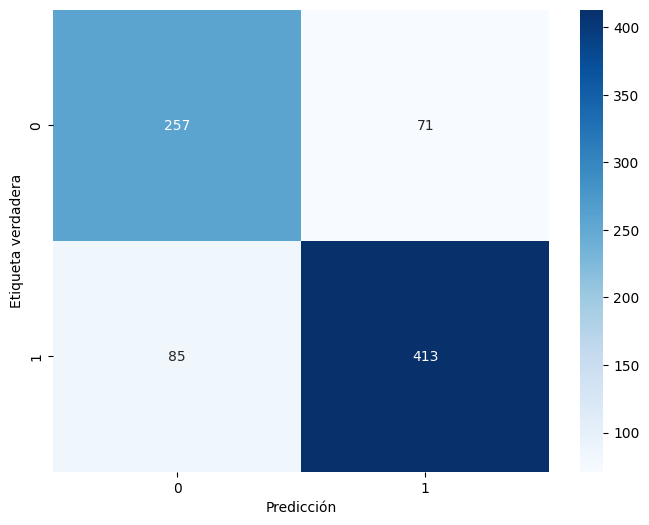

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
              precision    recall  f1-score   support

           0     0.6000    0.1364    0.2222        22
           1     0.7564    0.9672    0.8489        61

    accuracy                         0.7470        83
   macro avg     0.6782    0.5518    0.5356        83
weighted avg     0.7150    0.7470    0.6828        83



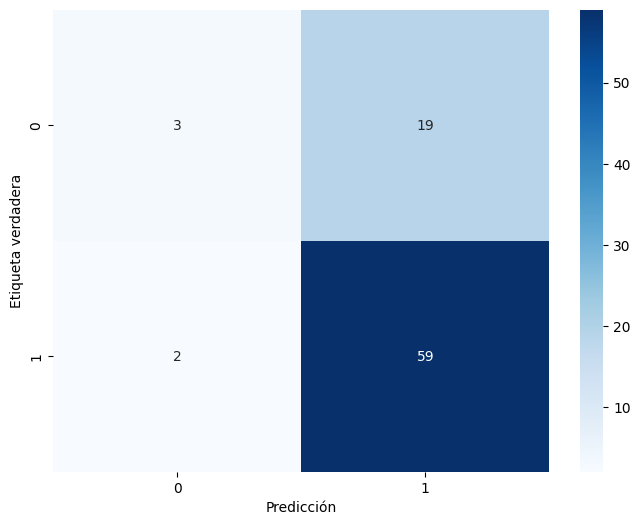

In [12]:
regression = False
tarea = 6
frozen=False
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression, frozen)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

Detección binaria de artrosis
Found 5778 validated image filenames belonging to 2 classes.
Detección binaria de artrosis
Found 826 validated image filenames belonging to 2 classes.
Detección binaria de artrosis
Found 83 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.5131 - loss: 1.1129🐾 [Cat Val] Loss: 0.5927 | Accuracy: 0.7349
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_accuracy improved from -inf to 0.60291, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 109s 489ms/step - accuracy: 0.5133 - loss: 1.1114 - val_accuracy: 0.6029 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 2/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.5464 - loss: 0.8075🐾 [Cat Val] Loss: 0.6188 | Accuracy: 0.7349

Epoch 2: val_accuracy did not improve from 0.60291
181/181 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.5464 - loss: 0.8074 - val_accuracy: 0.6029 - val_loss: 0.6719 - learning_rate: 0.0010
Epoch 3/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5509 - loss: 0.7485🐾 [Cat Val] Loss: 0.6105 | Accuracy: 0.7349

Epoch 3: val_accuracy did not improve from 0.60291
181/181 ━━━━━━━━━━━━━━━━━━━━ 65s 346ms/step - accuracy: 0.5509 - loss: 0.7483 - val_acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


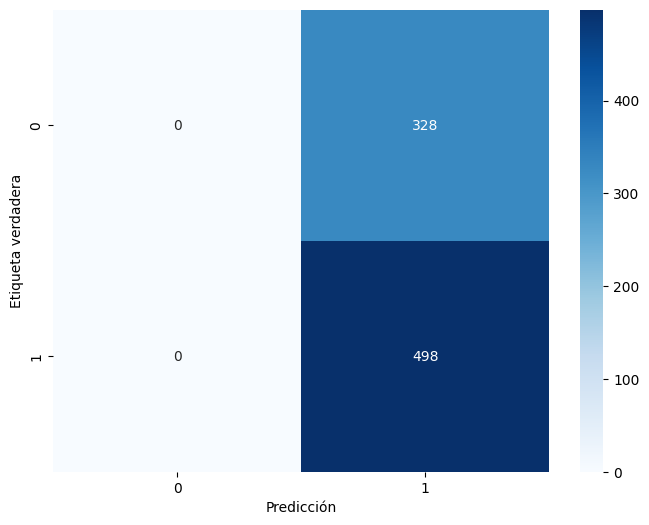

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        22
           1     0.7349    1.0000    0.8472        61

    accuracy                         0.7349        83
   macro avg     0.3675    0.5000    0.4236        83
weighted avg     0.5401    0.7349    0.6227        83



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


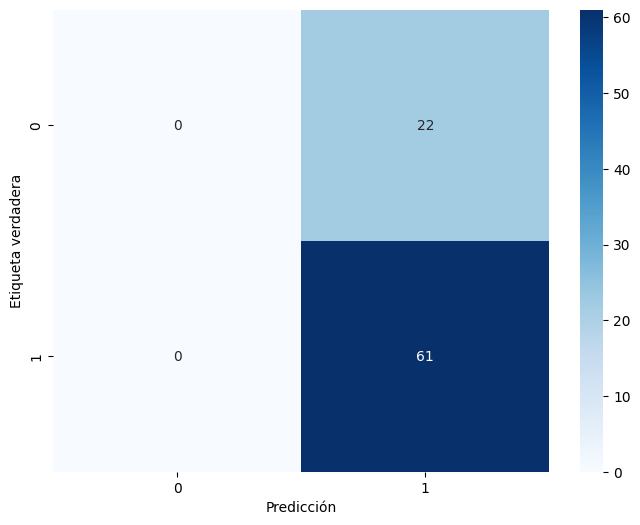

In [13]:
regression = False
tarea = 6
frozen=True
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression, frozen)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

# Anterior

## Exploración del dataset de artrosis de rodilla

- **Total de imágenes:** 9 786

| Partición      | Imágenes | Porcentaje |
|---------------|---------:|-----------:|
| **Train**      | 5 778    | 59.04 %    |
| **Validation** |   826    |  8.44 %    |
| **Test**       | 1 656    | 16.92 %    |
| **AutoTest**   | 1 526    | 15.59 %    |


### Distribución de clases en `Train`

|  Clase  | Índice | Imágenes | Porcentaje |
|---------|-------:|---------:|-----------:|
| Sin     |      0 |    2 286 |     39.56 % |
| Ligera  |      1 |    1 046 |     18.10 % |
| Leve    |      2 |    1 516 |     26.24 % |
| Moderada|      3 |      757 |     13.10 % |
| Severa  |      4 |      173 |      2.99 % |

